### import Library and Datasets

In [1]:
import numpy as np
import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
import os
import csv

from tqdm import tqdm

import shap
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from xgboost import XGBRegressor
import seaborn as sns
import ast

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
# For plotting learning curve

# from torch.utils.tensorboard import SummaryWriter

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
train_data = pd.read_csv("./dataset/Train.csv")

print(train_data.shape)
mixed_df = train_data.copy()
#Remove all categorical feature
is_string = train_data.applymap(lambda x: isinstance(x,str))
is_string_series = is_string.any()
string_col = is_string_series[is_string_series].index.tolist()
numerical_df = train_data.drop(string_col,axis=1)
numerical_df

(125973, 43)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,"""last_flag"""
0,0,491,0,0,0,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20
1,0,146,0,0,0,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15
2,0,0,0,0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19
3,0,232,8153,0,0,0,0,0,1,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21
4,0,199,420,0,0,0,0,0,1,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,0,0,0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,20
125969,8,105,145,0,0,0,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,21
125970,0,2231,384,0,0,0,0,0,1,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,18
125971,0,0,0,0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,20


# Numerical

### Heatmap

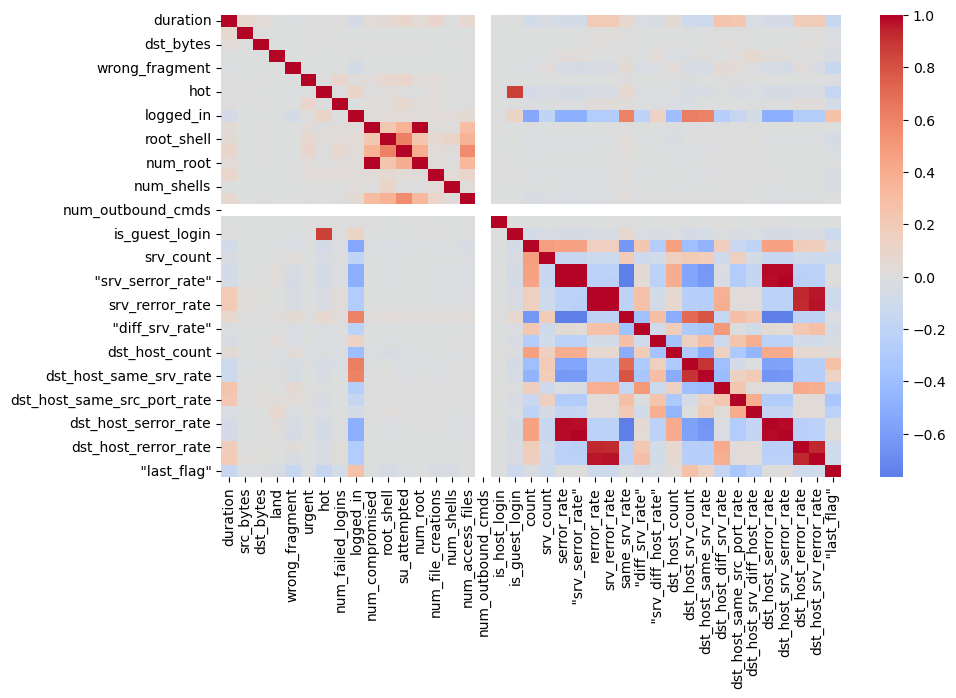

In [3]:
from sklearn.preprocessing import StandardScaler  # You can also use MinMaxScaler
features = list(numerical_df.columns)

scaler = StandardScaler()
normalized_data = scaler.fit_transform(numerical_df[features])


normalized_df = pd.DataFrame(normalized_data, columns=features)

corr_matrix = normalized_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.show()

### PCA

In [4]:
# Standardize Data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(numerical_df)
# Apply PCA
pca_2d = PCA(n_components=2)
pca_numerical_2d = pca_2d.fit_transform(df_scaled)
pca_numerical_2d_df = pd.DataFrame(data=pca_numerical_2d, columns = [f'PC{i+1}' for i in range(pca_numerical_2d.shape[1])])

pca_3d = PCA(n_components=3)
pca_numerical_3d = pca_3d.fit_transform(df_scaled)
pca_numerical_3d_df = pd.DataFrame(data = pca_numerical_3d,columns=[f'PC{i+1}' for i in range(pca_numerical_3d.shape[1])])

print(pca_numerical_2d_df.head())
print(pca_numerical_3d_df.head())

        PC1       PC2
0 -0.688405 -0.079682
1  0.665221  1.327677
2  3.698068 -1.453069
3 -2.387918 -1.108363
4 -2.166127 -0.954248
        PC1       PC2       PC3
0 -0.688406 -0.079682 -0.018028
1  0.665222  1.327673  0.143372
2  3.698068 -1.453068  0.036101
3 -2.387918 -1.108362 -0.114103
4 -2.166127 -0.954247 -0.169880


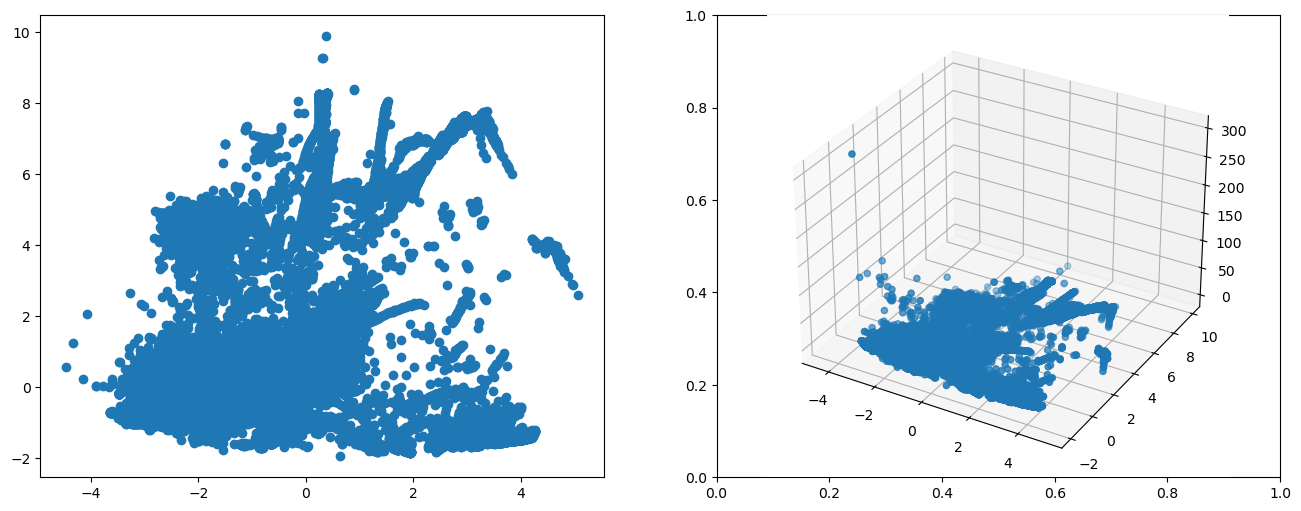

In [166]:


from mpl_toolkits.mplot3d import Axes3D
fig,ax = plt.subplots(1,2, figsize=(16,6))
ax[0].scatter(pca_numerical_2d[:,0],pca_numerical_2d[:,1])
ax[1] = fig.add_subplot(1,2,2,projection='3d')
ax[1].scatter(pca_numerical_3d[:,0],pca_numerical_3d[:,1],pca_numerical_3d[:,2])
# ax = fig.add_subplot(111,projection='3d')
# ax.scatter(pca_numerical[:,0],pca_numerical[:,1],pca_numerical[:,2])
plt.show()

### DBSCAN

In [167]:
#2d
dbscan_2d = DBSCAN(eps=0.5, min_samples=5)
dbscan_2d.fit(pca_numerical_2d)
#3d
dbscan_3d =DBSCAN(eps=0.5, min_samples=5)
dbscan_3d.fit(pca_numerical_3d)
#original data
dbscan_no_pca = DBSCAN(eps = 0.5, min_samples=5)
dbscan_no_pca.fit(df_scaled)

DBSCAN()

In [178]:
cluster_labels_2d = dbscan_2d.labels_
pca_numerical_2d_df['label'] = cluster_labels_2d
# pca_numerical_2d_df.loc[pca_numerical_2d_df['label'] == -1]
cluster_labels_3d = dbscan_3d.labels_
pca_numerical_3d_df['label'] = cluster_labels_3d

cluster_labels_no_pca = dbscan_no_pca.labels_

print(pca_numerical_2d_df.shape,pca_numerical_3d_df.shape)
print(pca_numerical_2d_df.head())
print(pca_numerical_3d_df.head())
print(cluster_labels_no_pca)

(125973, 3) (125973, 4)
        PC1       PC2  label
0 -0.688405 -0.079684      0
1  0.665222  1.327670      0
2  3.698068 -1.453070      0
3 -2.387918 -1.108365      0
4 -2.166127 -0.954252      0
        PC1       PC2       PC3  label
0 -0.688405 -0.079684 -0.017985      0
1  0.665220  1.327636  0.143794      0
2  3.698069 -1.453063  0.036028      0
3 -2.387918 -1.108362 -0.114190      0
4 -2.166127 -0.954251 -0.169889      0
125973


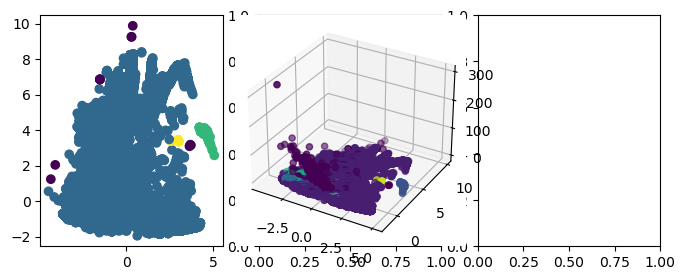

In [177]:
fig,ax = plt.subplots(1,3,figsize = (8,3))
ax[0].scatter(pca_numerical_2d_df['PC1'], pca_numerical_2d_df['PC2'],c = pca_numerical_2d_df['label'])
ax[1] = fig.add_subplot(1,1,1, projection='3d')
ax[1].scatter(pca_numerical_3d_df['PC1'],pca_numerical_3d_df['PC2'],pca_numerical_3d_df['PC3'], c=pca_numerical_3d_df['label'])
# pca_numerical_df=pca_numerical_df.loc[pca_numerical_df['label'] == -1]

PC1 and PC2 Variation is much higher than PC3

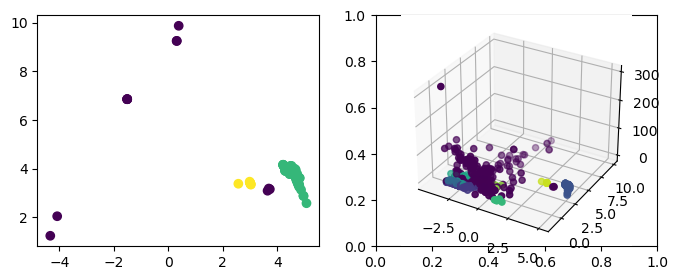

In [176]:
pca_numerical_2d_df_anomaly = pca_numerical_2d_df.loc[pca_numerical_2d_df['label'] != 0]
pca_numerical_3d_df_anomaly = pca_numerical_3d_df.loc[pca_numerical_3d_df['label'] != 0]

fig,ax = plt.subplots(1,2,figsize = (8,3))
ax[0].scatter(pca_numerical_2d_df_anomaly['PC1'], pca_numerical_2d_df_anomaly['PC2'],c = pca_numerical_2d_df_anomaly['label'])
ax[1] = fig.add_subplot(1,2,2, projection='3d')
ax[1].scatter(pca_numerical_3d_df_anomaly['PC1'],pca_numerical_3d_df_anomaly['PC2'],pca_numerical_3d_df_anomaly['PC3'], c=pca_numerical_3d_df_anomaly['label'])

In [184]:
#Get outlier index and add it to the original dataframe
predicted_df = train_data.copy()
predicted_df['attack_bool'] = predicted_df['attack'] != 'normal'
predicted_df['prediction']=cluster_labels_3d != 0
predicted_df.to_csv('prediction.csv')

#Calculate the accuracy
n_correct_prediction = (predicted_df['attack_bool'] == predicted_df['prediction']).sum()
accuracy = n_correct_prediction/predicted_df.shape[0]
accuracy 


0.5316536083128924

# Gower Dissimilarity for Mixed Data Types

In [186]:
mixed_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,"""last_flag"""
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [6]:
import gower
scaler = StandardScaler()
n_samples = 25000
mixed_df_cropped = mixed_df[:n_samples].copy()
distance_matrix = gower.gower_matrix(mixed_df_cropped)


In [ ]:
sns.heatmap(distance_matrix,cmap='plasma',annot=False, center=0)

<Axes: >

: 

: 

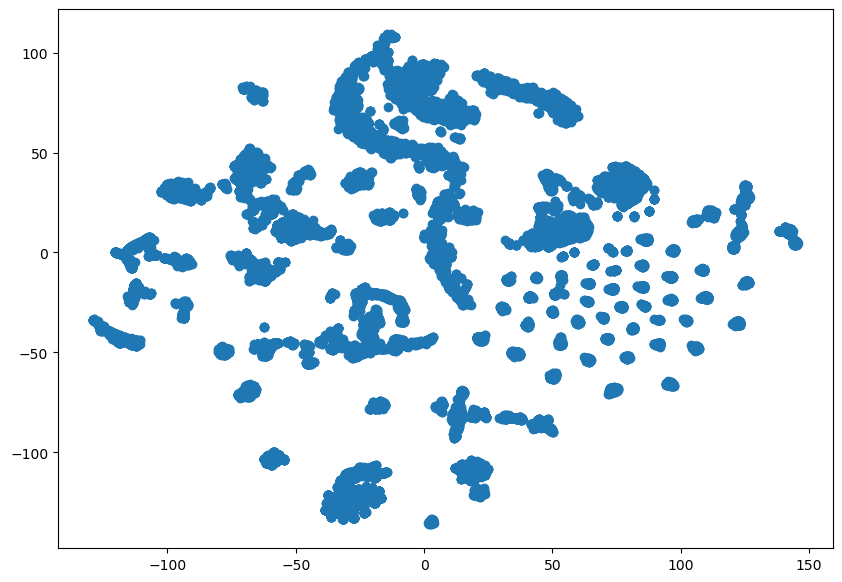

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, metric="precomputed", init='random',learning_rate='auto', perplexity=100, n_iter=4000)
tsne_results = tsne.fit_transform(distance_matrix)

plt.figure(figsize=(10,7))
plt.scatter(tsne_results[:,0], tsne_results[:,1])

In [8]:
dbscan_t_sne = DBSCAN(eps=14, min_samples=40)
dbscan_t_sne.fit(tsne_results)
cluster_labels_t_sne = dbscan_t_sne.labels_

In [9]:
# dbscan = DBSCAN(eps=0.04, min_samples=5, metric='precomputed') #Because range of Gower Dissimilarity is between 0 to 1
dbscan = DBSCAN(eps=0.05, min_samples=4, metric='precomputed') #Because range of Gower Dissimilarity is between 0 to 1

dbscan.fit_predict(distance_matrix)
cluster_labels = dbscan.labels_

In [10]:
from sklearn.preprocessing import LabelEncoder
#Encode the attack categories to labels
le = LabelEncoder()
le.fit(mixed_df_cropped['attack'].astype('category'))
print(le.classes_)
s = le.transform(mixed_df_cropped['attack'])


tsne_results_df = pd.DataFrame(tsne_results)
tsne_results_df['attack'] = s
tsne_results_df['t_sne_label'] = cluster_labels_t_sne
tsne_results_df['normal_label'] = cluster_labels
tsne_results_df
mixed_df_cropped['normal_label'] = cluster_labels
mixed_df_cropped['t_sne_label'] = cluster_labels_t_sne
mixed_df_cropped.to_csv('prediction_mixed.csv')

['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'phf' 'pod'
 'portsweep' 'rootkit' 'satan' 'smurf' 'spy' 'teardrop' 'warezclient'
 'warezmaster']


(25000, 5)


Text(0.5, 1.0, 'with t-sne')

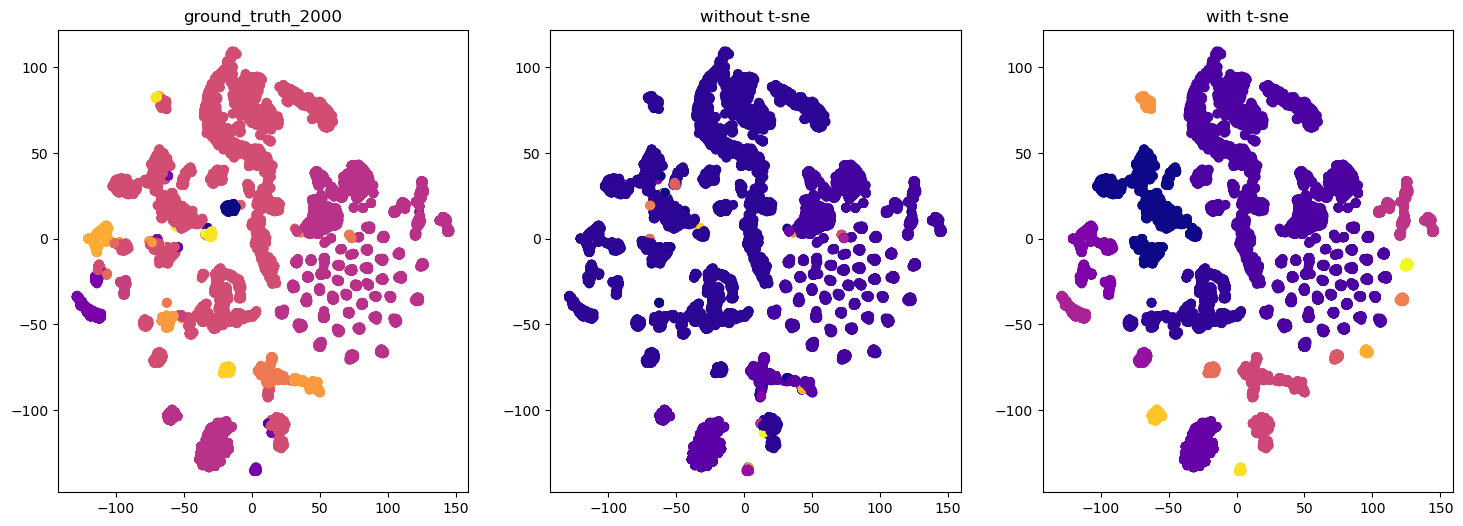

In [11]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
df = tsne_results_df.loc[tsne_results_df['attack'] != 220]
print(df.shape)
ax[0].scatter(df[0], df[1],c=df['attack'], cmap='plasma')
ax[0].set_title("ground_truth_2000")
ax[1].scatter(df[0], df[1],c=df['normal_label'], cmap='plasma')
ax[1].set_title("without t-sne")
ax[2].scatter(df[0], df[1],c=df['t_sne_label'], cmap='plasma')
ax[2].set_title("with t-sne")
#important labels: 0, 5, 9, 10, 11, 14, 16, 17, 19, 20

In [652]:
mixed_df_cropped

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,"""last_flag""",normal_label,t_sne_label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0,1
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1,2
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,icmp,eco_i,SF,8,0,0,0,0,0,...,1.00,0.50,0.00,0.00,0.00,0.00,ipsweep,18,0,7
39996,0,tcp,link,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20,1,28
39997,0,tcp,http,SF,229,14173,0,0,0,0,...,0.03,0.07,0.00,0.00,0.00,0.00,normal,21,0,0
39998,0,tcp,http,SF,220,1748,0,0,0,0,...,0.06,0.11,0.00,0.02,0.00,0.00,normal,21,0,0


In [653]:
#Accuracy
#Find the mode of which the cluster is associated to
df = mixed_df_cropped.copy()
mapping_dict = {0:'normal', 1:'neptune', 2:'portsweep', 3: 'ipsweep', 4: 'teardrop', 5: 'satan'}
df['normal_label'] = df['normal_label'].map(lambda x: mapping_dict.get(x,'undefined'))
df['t_sne_label'] = df['t_sne_label'].map(lambda x: mapping_dict.get(x,'undefined'))
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,"""last_flag""",normal_label,t_sne_label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal,neptune
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,neptune,portsweep
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,icmp,eco_i,SF,8,0,0,0,0,0,...,1.00,0.50,0.00,0.00,0.00,0.00,ipsweep,18,normal,undefined
39996,0,tcp,link,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20,neptune,undefined
39997,0,tcp,http,SF,229,14173,0,0,0,0,...,0.03,0.07,0.00,0.00,0.00,0.00,normal,21,normal,normal
39998,0,tcp,http,SF,220,1748,0,0,0,0,...,0.06,0.11,0.00,0.02,0.00,0.00,normal,21,normal,normal


In [661]:
acc_df = df.loc[df['attack'] == df['normal_label']]


accuracy_dict = {'normal':0, 'neptune': 0, 'portsweep':0, 'ipsweep':0, 'teardrop':0, 'satan': 0}
total_acc = 0
for key, _ in accuracy_dict.items():
  non_key_df = df.loc[df['attack'] != key]
  n_false_prediction = non_key_df.loc[non_key_df['normal_label'] == key].shape[0]  
  accuracy_dict[key] = acc_df.loc[acc_df['attack'] == key].shape[0] / (df.loc[df['attack'] == key].shape[0] + n_false_prediction)
  print(n_false_prediction)
  total_acc = accuracy_dict[key]
mistake_count = df.loc[df['normal_label']=='undefined'].shape[0]
print(mistake_count)
accuracy_dict

3655
0
2900
69
124
11
240


{'normal': 0.8468237088165657,
 'neptune': 0.8349360187779208,
 'portsweep': 0.2266701325708344,
 'ipsweep': 0.0,
 'teardrop': 0.0,
 'satan': 0.0}

<BarContainer object of 6 artists>

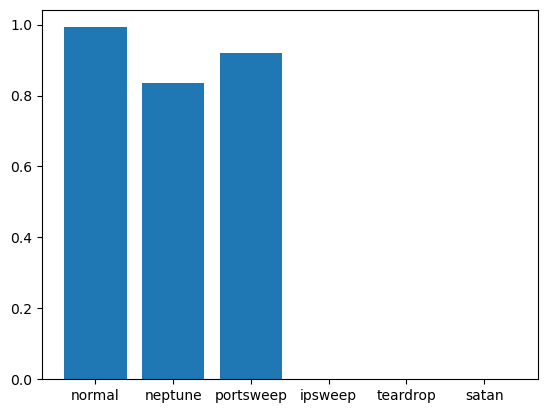

In [655]:
categories = list(accuracy_dict.keys())
values = list(accuracy_dict.values())
plt.bar(categories,values)

In [662]:
#Bayesian - Parameters to set => DBSCAN, 
from bayes_opt import BayesianOptimization

# 1. Specify Parameter Search Space
pbounds = {'eps':(0.03,0.05), 'min_samples':(3,15)}
# 2. Specify Blackbox Function
def total_acc(eps, min_samples):
  dbscan = DBSCAN(eps=eps, min_samples=int(min_samples), metric='precomputed') #Because range of Gower Dissimilarity is between 0 to 1
  dbscan.fit_predict(distance_matrix)
  cluster_labels = dbscan.labels_  
  df = mixed_df_cropped.copy()
  df['normal_label'] = cluster_labels
  mapping_dict = {0:'normal', 1:'neptune', 2:'portsweep', 3: 'ipsweep', 4: 'teardrop', 5: 'satan'}
  df['normal_label'] = df['normal_label'].map(lambda x: mapping_dict.get(x,'undefined'))
  acc_df = df.loc[df['attack'] == df['normal_label']]
  total_acc = 0
  for key, _ in accuracy_dict.items():
    non_key_df = df.loc[df['attack'] != key]
    n_false_prediction = non_key_df.loc[non_key_df['normal_label'] == key].shape[0]  
    accuracy_dict[key] = acc_df.loc[acc_df['attack'] == key].shape[0] / df.loc[df['attack'] == key].shape[0]
    total_acc += accuracy_dict[key]
  mistake_count = df.loc[df['normal_label']=='undefined'].shape[0]
  return total_acc

# 3. Apply Boptimizer 
optimizer = BayesianOptimization(
  f=total_acc,
  pbounds=pbounds,
  random_state=1,
)
optimizer.maximize(
  init_points = 0,
  n_iter=100
)

|   iter    |  target   |    eps    | min_sa... |
-------------------------------------------------


KeyboardInterrupt: 

In [565]:
dbscan = DBSCAN(eps=0.01, min_samples=int(5), metric='precomputed') #Because range of Gower Dissimilarity is between 0 to 1
dbscan.fit_predict(distance_matrix)
cluster_labels = dbscan.labels_  
df = mixed_df_cropped.copy()
df['normal_label'] = cluster_labels
mapping_dict = {0:'normal', 1:'neptune', 2:'portsweep', 3: 'ipsweep', 4: 'teardrop', 5: 'satan'}
df['normal_label'] = df['normal_label'].map(lambda x: mapping_dict.get(x,'undefined'))
acc_df = df.loc[df['attack'] == df['normal_label']]
total_acc = 0
for key, _ in accuracy_dict.items():
  accuracy_dict[key] = acc_df.loc[acc_df['attack'] == key].shape[0] / df.loc[df['attack'] == key].shape[0]
  total_acc += accuracy_dict[key]
mistake_count = df.loc[df['normal_label']=='undefined'].shape[0]
accuracy_dict

{'normal': 0.017605633802816902,
 'neptune': 0.30849768687606527,
 'portsweep': 0.0,
 'ipsweep': 0.0,
 'teardrop': 0.0,
 'satan': 0.0}